## OLD: ULMFiT-2 Blue-or-Red Training: 2022 Tweets

In [1]:
from fastai.text.all import *
from rich import inspect

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from ideology_utils import *
#from get_legislators import *
#from ideology_score import blue_red_score

In [7]:
path = Path()
path_22 = 'tweets-2022-05-24'
path_19 = '/home/cdaniels/fastai-projects/blue-or-red/data_full'

In [8]:
df_22 = pd.read_csv("blue_red_training_valid.csv").sample(frac=1)
df_19 = pd.read_csv("blue_red_training_valid_2019.csv").sample(frac=1)

In [6]:
df = df_22

In [8]:
df.shape

(17139, 2)

### Fine-tuning a language model on Congressional Tweets from 2019

In [82]:
dls_lm = TextDataLoaders.from_df(df, is_lm=True, text_col='text', label_col='party', valid_pct=.1, bs=128)

In [84]:
dls_lm.show_batch(max_n=5)

,text,text_
0,xxbos xxmaj see you soon ! xxbos xxmaj insulin was discovered a century ago yet today it can cost families more than $ xxunk / month . xxmaj patients are suffering because of xxmaj big xxmaj pharma ’s unacceptable price spikes . xxmaj i ’m at xxunk sharing my support for the xxmaj affordable xxmaj insulin xxmaj now xxmaj act to cap the price of insulin at $ 35 / month .,xxmaj see you soon ! xxbos xxmaj insulin was discovered a century ago yet today it can cost families more than $ xxunk / month . xxmaj patients are suffering because of xxmaj big xxmaj pharma ’s unacceptable price spikes . xxmaj i ’m at xxunk sharing my support for the xxmaj affordable xxmaj insulin xxmaj now xxmaj act to cap the price of insulin at $ 35 / month . xxbos
1,a union . xxmaj that 's why i support the # proact to empower workers and protect their right to organize . xxbos xxmaj worse than the leak ( xxunk ) is the opinion ( unconscionable ) stripping away women ’s rights . xxup scotus stands ready to revoke abortion access reproductive justice & & the right for every person to make their own decisions about their bodies & & their,union . xxmaj that 's why i support the # proact to empower workers and protect their right to organize . xxbos xxmaj worse than the leak ( xxunk ) is the opinion ( unconscionable ) stripping away women ’s rights . xxup scotus stands ready to revoke abortion access reproductive justice & & the right for every person to make their own decisions about their bodies & & their health
2,community to experience this tragedy . xxbos xxmaj as a grandmother i understand the importance of keeping our babies well - xxunk & & content . xxmaj that ’s why i joined @housedemocrats to take action to ensure parents & & guardians can find safe affordable formula on their grocery store shelves . xxbos xxmaj my bipartisan xxmaj lactation xxmaj spaces for xxmaj veteran xxmaj moms xxmaj act expands access to clean,to experience this tragedy . xxbos xxmaj as a grandmother i understand the importance of keeping our babies well - xxunk & & content . xxmaj that ’s why i joined @housedemocrats to take action to ensure parents & & guardians can find safe affordable formula on their grocery store shelves . xxbos xxmaj my bipartisan xxmaj lactation xxmaj spaces for xxmaj veteran xxmaj moms xxmaj act expands access to clean safe
3,with xxmaj california ’s xxunk today — outstanding xxup k-12 educators serving in the national education arena . xxmaj our country ’s xxup stem education policies will be better for their input . xxbos xxmaj we need to fund — not defund — local law enforcement to keep them and our communities safe . xxbos xxmaj border security xxup is national security . xxmaj the xxmaj biden xxmaj administration now has the,xxmaj california ’s xxunk today — outstanding xxup k-12 educators serving in the national education arena . xxmaj our country ’s xxup stem education policies will be better for their input . xxbos xxmaj we need to fund — not defund — local law enforcement to keep them and our communities safe . xxbos xxmaj border security xxup is national security . xxmaj the xxmaj biden xxmaj administration now has the worst
4,across the country passed the xxmaj house . w / it we 're keeping our promise to our vets . xxbos xxmaj great to be able to check out an active oil xxunk today with @repbilljohnson and @repnewhouse to see how we fuel xxmaj america ! @westerncaucus xxbos xxmaj absolutely heartbroken about the xxmaj buffalo shooting . xxmaj my prayers are going out to the families of the 10 lives that were,the country passed the xxmaj house . w / it we 're keeping our promise to our vets . xxbos xxmaj great to be able to check out an active oil xxunk today with @repbilljohnson and @repnewhouse to see how we fuel xxmaj america ! @westerncaucus xxbos xxmaj absolutely heartbroken about the xxmaj buffalo shooting . xxmaj my prayers are going out to the families of the 10 lives that were lost


In [100]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

SuggestedLRs(valley=0.0030199517495930195)

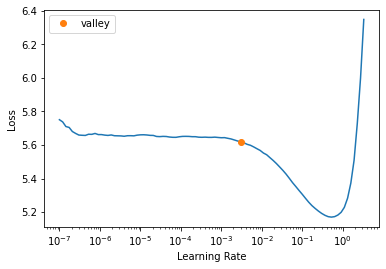

In [86]:
learn.lr_find()

In [101]:
learn.fit_one_cycle(1, .003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.950199,4.385639,0.270096,80.289490,00:30


In [102]:
learn.unfreeze()
learn.fit_one_cycle(10, .003)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.307137,3.829490,0.321040,46.039070,00:31
1,3.904913,3.430416,0.359396,30.889486,00:31
2,3.595438,3.221178,0.384288,25.057629,00:31
3,3.324554,3.122995,0.395966,22.714310,00:31
4,3.081956,3.035201,0.408955,20.805161,00:31
5,2.905645,2.985678,0.416992,19.799917,00:31
6,2.737708,2.950382,0.425589,19.113262,00:31
7,2.604995,2.934146,0.429626,18.805435,00:31
8,2.519115,2.931334,0.431829,18.752634,00:31
9,2.459337,2.930697,0.432741,18.740688,00:31


In [103]:
learn.save_encoder('finetuned')

### Training a text classifier

In [152]:
dls_clas = TextDataLoaders.from_df(df, valid_pct=.2, text_col='text', label='party', text_vocab=dls_lm.vocab, bs=128)

In [153]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [154]:
learn = learn.load_encoder('finetuned')

SuggestedLRs(valley=0.0010000000474974513)

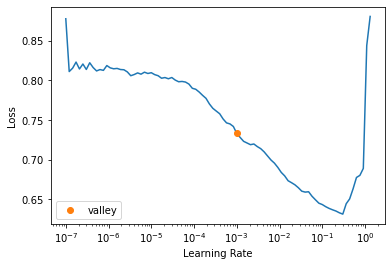

In [146]:
learn.lr_find()

In [155]:
learn.fit_one_cycle(1, .001)

epoch,train_loss,valid_loss,accuracy,time
0,0.517602,0.455422,0.777648,00:06


In [156]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.473744,0.423932,0.805369,00:07


In [157]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.429677,0.386798,0.819376,00:09


In [158]:
learn.freeze_to(-4)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.359038,0.368743,0.831631,00:10


In [159]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.289483,0.369055,0.840969,00:11
1,0.248606,0.376854,0.841552,00:11


In [160]:
learn.export("ulmfit.pkl")

###  Load Model

In [ ]:
learn = load_learner("ulmfit.pkl")

In [161]:
blue_red_score(Path(path_19)/"McConnellPress.csv","ulmfit.pkl")

['McConnellPress', 0.63, 0.6, 1451]